# Demand Forecast of 50 Items at 10 Store Locations
**Author**: Pinyo Taeprasartsit

**Objectives**
1. To explore sales data, especially how sales of two products and store locations correlated.
2. Confirm by autocorrelation of item sales whether there is a strong cycle signal. (Experiments confirmed that the 
   strongest cyclic pattern existed with the period of 7 days.)
3. Train CycleNet, a state-of-the-art model (as of 2024), that explicitly employs a cyclic pattern underlying the data.
   This means we provide W = 7 into the model settings.
4. Use trained CycleNet to forecast sales. Due to the expected forecast length is the whole year, the trained model 
   cannot perform such a feat in one go. So, we need to loop back the forecast as the input to extend prediction 
   horizon. This behavior is visualized in the forecast examples of various items and stores below. 

In the figures below, sales forecasting was performed in a batch of 98 days. The outputs from the first batch were 
concatenated to the input of the first batch to form the input for the second batch. This process was done until
we obtained batch-4 outputs. The outputs from the 4 batches are joined to create the forecast of the entire year.
(To be exact, the forecast went a little beyond a year.)
![Autocorrelation of Item-1 sales at Store3](./results/SalesDoubleMultivarAll_seq_400_pred_98_CycleNet_Sales_ftM_sl400_pl98_cycle7_mlp_seed2024/in_out_batch1_2_3_4_it1_st3.png)
![Autocorrelation of Item-2 sales at Store8](./results/SalesDoubleMultivarAll_seq_400_pred_98_CycleNet_Sales_ftM_sl400_pl98_cycle7_mlp_seed2024/in_out_batch1_2_3_4_it2_st8.png)
![Autocorrelation of Item-7 sales at Store2](./results/SalesDoubleMultivarAll_seq_400_pred_98_CycleNet_Sales_ftM_sl400_pl98_cycle7_mlp_seed2024/in_out_batch1_2_3_4_it7_st2.png)
![Autocorrelation of Item-9 sales at Store10](./results/SalesDoubleMultivarAll_seq_400_pred_98_CycleNet_Sales_ftM_sl400_pl98_cycle7_mlp_seed2024/in_out_batch1_2_3_4_it7_st2.png)


**Quick Takeaways**
1. Almost all items in any stores exhibit a significant cyclic pattern with the dominant autocorrelation amplitude > 0.5.
As an example, this figure shows autocorrelation during a 400-days period of Item-1 sales at Store 1.<br>
![Autocorrelation of Item-1 sales at Store1](./Figures/autocorr_store1_item1.png)
2. The strongest cyclic pattern corresponds to a 7-days period. Interestingly, the period of about 365 days also produces a
   strong cyclic pattern, but it is obviously weaker than the 7-days period (see the above figure).
3. Stores 5, 6, and 7 have relatively irregular sales pattern when compared with other stores. Forecasting sales on
   these stores may be less accurate.
4. Items 5 and 27 possess a weak cyclic pattern. Also, Items 1, 4, 41, and 47 have a somewhat weak cyclic pattern.
   Forecasting sales for these items will be less accurate.
5. Cross-correlations between two items in the same store indicate that they are correlate in most item pairs, 
   although correlation may not be strong in many pairs (0.6 > correlation amplitude > 0.5).
6. The same goes for cross-correlation between two items across stores, except for Stores 5, 6, and 7 whose item 
   autocorrelations are weak to begin with.
7. The model is set up as a multivariate solution for both input and output. It takes multiple sales column as an input
   and produce multiple sales forecast of multiple items in one prediction.

**Overview of Model and Its Settings**
1. Model is based on [CycleNet](https://neurips.cc/virtual/2024/poster/94391) proposed by Shengsheng Lin et al. in NeurIPS 2024. The paper received NeurIPS spotlight. 
2. Its [GitHub repo is available](https://github.com/ACAT-SCUT/CycleNet/tree/main). However, their code was geared toward research publication, not real use.
Therefore, I had to hack their code to make it runnable in a new dataset and able to support a longer prediction horizon. (I almost regret about choosing this model for the experiments.)
3. CycleNet is a competent model based on deep learning. However, it needs a lot of hyperparameter tuning. I am sure that there is a headroom to squeeze more
accuracy from it, but each training session may take a few hours. For the moment, I could not afford much time to try many things.
4. There are other strong models coming out in 2024, including [SOFTS](https://github.com/Secilia-Cxy/SOFTS), TimeMixer, and iTransformer. I want to try them too, but time is limited, so I choose CycleNet because I am curious about its effort to explictly learn cycle parameters.
5. CycleNet comes with two major architectural variants: linear and multi-layer perceptrons (MLP). My quick survey on the sales data indicated that the MLP variant was more accurate. So, I chose this variant, but extensive experiments are required to validate their performance.
6. It is possible to build a univariate model based data of only one item and one store. 
Then, doing the same to cover the entire 500 models covering the entire combination of 50 items x 10 stores.
However, this may lack both efficiency and accuracy because such a univariate model cannot exploit potential relationship among items and stores.
For example, the sales of ice and soft drinks may be highly correlated. Therefore, putting data of these items together for training can
potentially improve the performance.
7. Since my data exploration indicates that sales data between items whether in the same or cross stores have significant cross-correlation
for the great majority of the times, I decided to build a multivariate model for both input and output. In other words, the model will take
multiple sales columns as input and forecast multiple sales of items and/or stores in one prediction.
8. The model is set to have 98 days of the prediction horizon (forecast sales of 98 days). The test outputs, however, asks for 365-days forecast.
Consequently, I will perform the forecast 4 times. The outputs from the first forecast will be concatenated with the former input so that the
forecasting timeline moves into the next 3 months. The same forecast and concatenation process will continue until the outputs cover the needed 365 days.
9. It is possible to build a model with prediction horizon of 365 days so that sales forecast can be done in one go. Unfortunately, the training data covers only 5 years. If the output sequence is that long the number of possible training samples may be too small. I, myself, want to compare this 365 days
configuration with 98 days, but training the model takes long.

# Initial Setup and Data Loading

In [99]:
import numpy as np
import pandas as pd
from ipydatagrid import DataGrid
from datetime import datetime

# For correlation and data cycle evaluation
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from scipy.signal import find_peaks

## Loading and Peeking at Data

In [85]:
base_folder = "C:/Users/pinyo/OneDrive/Data/Gosoft/demand-forecasting"
orig_train_path = f"{base_folder}/train.csv"

In [86]:
df_raw = pd.read_csv(orig_train_path)
DataGrid(df_raw)

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [87]:
# Test data query and expected table shape of each item by sampling at Store 1, Item 2.
store1_item2 = df_raw.query("store == 1 & item == 2")
print(f"Table shape = {store1_item2.shape}")
DataGrid(store1_item2)

Table shape = (1826, 4)


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

# Checking Data Sanity
1. All items should have exactly 1826.
2. Time stamps of adjacent rows should differ by exactly 1 day.

I will make sure that these data properties stand throughout all 50 items and 10 stores so that we can further organize the data with confidence.

## Separating data by stores and items

In [23]:
stores = dict()
for store in range(1, 11):
    items = dict()
    for item in range(1, 51):
        items[item] = df_raw.query(f"store == {store} & item == {item}")
    stores[store] = items

## Sanity Checking Routines

In [70]:
def check_num_rows(stores):
    """All items should have exactly 1826 rows which means (365 * 5) + 1 data days."""

    target_num_rows = 1826
    print(f"Checking the number of rows of each item: target = {target_num_rows} rows.")
    for store in range(1, 11):
        for item in range(1, 51):
            assert stores[store][item].shape[0] == target_num_rows
    print("Row number checking: PASSED")


def check_date_diff(stores):
    """All adjacent rows should be different by 1 day."""

    # Get target time difference from the first two rows of Store 1 and Item 1.
    date1 = datetime.strptime(stores[1][1]['date'][1], '%Y-%m-%d').date()
    date0 = datetime.strptime(stores[1][1]['date'][0], '%Y-%m-%d').date()
    target_date_diff = date1 - date0
    print(f"Target difference date = {target_date_diff}")

    for store in range(1, 11):
        print(f"Checking date data in Store {store}")
        for item in range(1, 51):
            dates = stores[store][item]['date']
            dates = dates.reset_index(drop=True)
            date0 = datetime.strptime(dates[0], "%Y-%m-%d").date()
            for curr_date in dates[1:]:
                date1 = datetime.strptime(curr_date, "%Y-%m-%d").date()
                assert (date1 - date0) == target_date_diff
                date0 = date1
    print("Date difference checking: PASSED")


store, item = 10, 50
print(f"Table shape = {stores[store][item].shape}")
check_num_rows(stores)
check_date_diff(stores)

# The output below should show "Row number checking: PASSED" and "Date difference checking: PASSED" without any assertion failure.

Table shape = (1826, 4)
Checking the number of rows of each item: target = 1826 rows.
Row number checking: PASSED
Target difference date = 1 day, 0:00:00
Checking date data in Store 1
Checking date data in Store 2
Checking date data in Store 3
Checking date data in Store 4
Checking date data in Store 5
Checking date data in Store 6
Checking date data in Store 7
Checking date data in Store 8
Checking date data in Store 9
Checking date data in Store 10
Date difference checking: PASSED


# Evaluate Existence of Cycles for Seasonal-Trend Decomposition
Mainly done by auto-correlation on sales of each item and store. Although a yearly or monthly cycle may sound natural, we will check this out by autocorrelation. Dominant trends will exhibit themselves if any. Our first thought may be reasonable, but not the best.

## Item Autocorrelation
The CycleNet explicitly exploits the cycle of events. Therefore, we have to verify if there is any dominant cycle period.
Also, if there is, what is dominant period W that we will put into the model to capture.

In [176]:
def compute_and_plot_autocorrelation_of_item_sales(store, item, day_lags=400, xsize=12, ysize=2.5,
                                                   show_plot=True, save=False, save_folder=None):
    """Compute and plot autocorrelation of a specific item at a specific store, plot the output. If desired,
    we can also save the plot to a PNG file. Autocorrelation values are returned for further analysis."""

    # Calculate autocorrelation coefficients
    sales = stores[store][item]['sales']
    acf_values = acf(sales, nlags=day_lags)

    plt.ioff()

    # Plot the bar chart
    lags = np.arange(len(acf_values))
    plt.figure(figsize=(xsize, ysize))
    plt.bar(lags, acf_values)  # use bar plot

    plt.xlim([0, day_lags])
    plt.ylim([0, 1])

    plt.title(f"Sales Autocorrelation of Store {store}, Item {item}", fontsize=11)
    plt.xlabel("Day Lags", fontsize=10)
    plt.ylabel("Autocorrelation", fontsize=10)

    plt.grid(True)

    if save:
        assert save_folder is not None
        plt.savefig(f"{save_folder}/autocorr_store{store}_item{item}.png", bbox_inches='tight')

    if show_plot:
        plt.show()
    plt.close()
        
    return acf_values

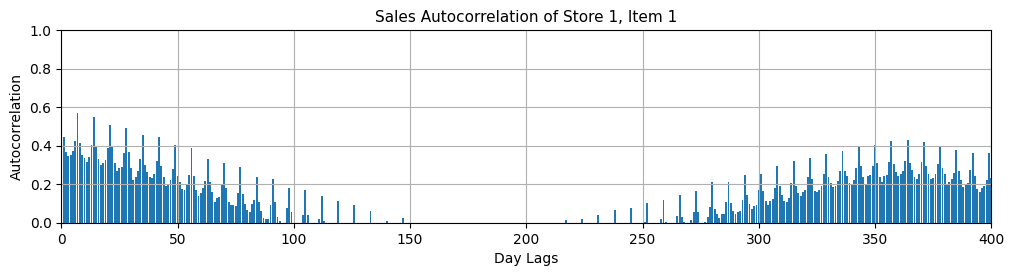

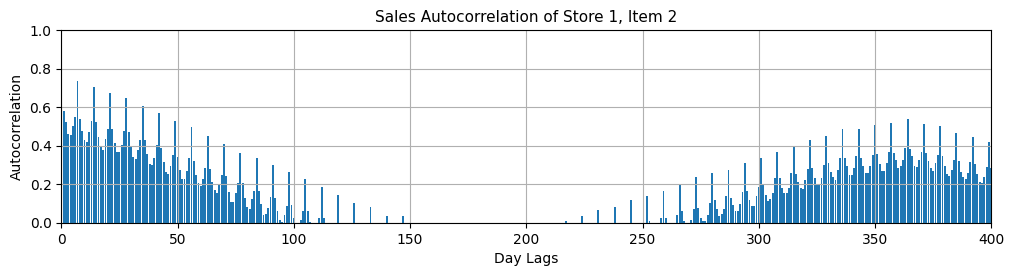

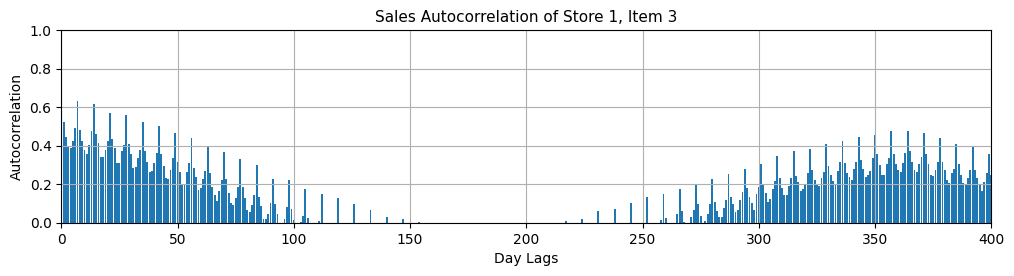

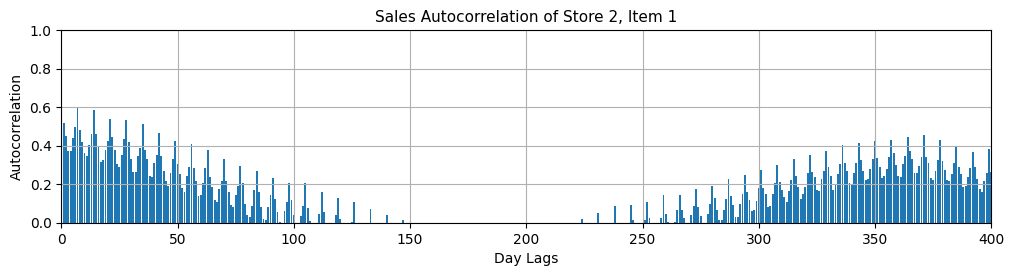

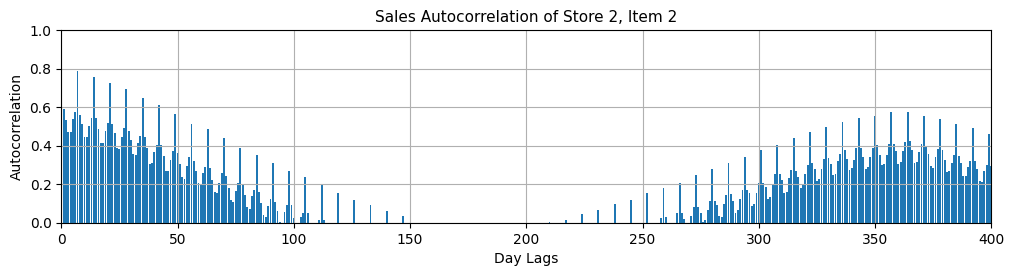

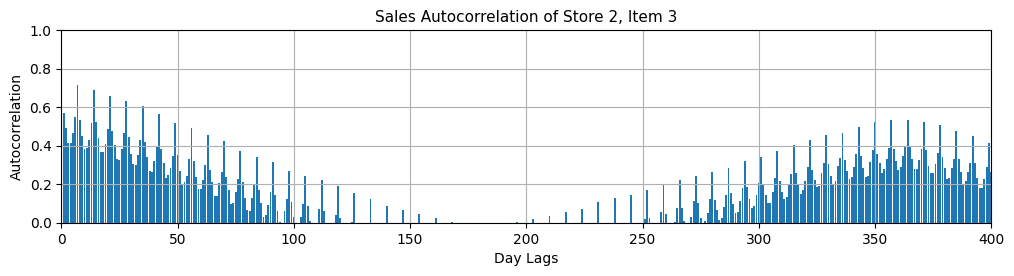

In [155]:
# Visualize autocorrelation of Items 1, 2, 3 at Stores 1 and 2.

show_plot = True
save_plot = True  # Save the plots for offline analysis
autocorr_folder = f"{base_folder}/images/autocorrelation"
_ = compute_and_plot_autocorrelation_of_item_sales(store=1, item=1, show_plot=show_plot, save=save_plot, save_folder=autocorr_folder)
_ = compute_and_plot_autocorrelation_of_item_sales(store=1, item=2, show_plot=show_plot, save=save_plot, save_folder=autocorr_folder)
_ = compute_and_plot_autocorrelation_of_item_sales(store=1, item=3, show_plot=show_plot, save=save_plot, save_folder=autocorr_folder)

_ = compute_and_plot_autocorrelation_of_item_sales(store=2, item=1, show_plot=show_plot, save=save_plot, save_folder=autocorr_folder)
_ = compute_and_plot_autocorrelation_of_item_sales(store=2, item=2, show_plot=show_plot, save=save_plot, save_folder=autocorr_folder)
_ = compute_and_plot_autocorrelation_of_item_sales(store=2, item=3, show_plot=show_plot, save=save_plot, save_folder=autocorr_folder)

# From the plots we see below, it is clear that a yearly cycle is not dominant, albeit its strength. 
# I think the dominant cycle is probably 7 days (weekly cycle). Let's get the numbers out.

In [148]:
# Perform autocorrelations for all items at all stores. We calculate autocorrelation for 50 x 10 = 500 times.
# There are too much too do eye-ball verification. So, we will ...
# Step 1. Calculate all autocorrelations and save their values.
# Step 2. Find peaks and record the domininant peak positions and amplitudes of each time.
# Step 3. Display only peaks and their number of times being dominant.
# Step 4. Verify the peak amplitude. Low amplitude may indicate that the item does not have a strong cyclic pattern.

# Step 1. Calculate all autocorrelations and save their values.
show_plot = False  # Do not display plots, too many to manually check in Jupyter.
save_plot = True  # Save the plots for offline analysis
autocorr_folder = f"{base_folder}/images/autocorrelation"

all_acf = dict()
for store in range(1, 11):
    item_acf = dict()
    for item in range(1, 51):
        item_acf[item] = compute_and_plot_autocorrelation_of_item_sales(store=store, item=item, show_plot=show_plot, 
                                                                        save=save_plot, save_folder=autocorr_folder)
    all_acf[store] = item_acf


C:\Users\pinyo\AppData\Local\Temp\ipykernel_37556\3604663941.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(xsize, ysize))


In [ ]:
# Step 2. Find peaks and record the domininant peak positions and amplitudes of each time.
dominant_periods = dict()
for store in range(1, 11):
    for item in range(1, 51):
        peaks, _ = find_peaks(all_acf[store][item])
        dom_period = peaks[0]
        if dom_period in dominant_periods:
            dominant_periods[dom_period] += 1
        else:
            dominant_periods[dom_period] = 1

In [157]:
# Step 3. Display only peaks and their number of times being dominant.
for period in dominant_periods:
    dom_times = dominant_periods[period]
    if dom_times > 0:
        print(f"Dominant period: {period} days being dominant for {dom_times} times")

Dominant period: 7 days being dominant for 495 times
Dominant period: 3 days being dominant for 1 times
Dominant period: 4 days being dominant for 2 times
Dominant period: 5 days being dominant for 2 times


From the result above, 7 days is the dominant cycle periods for 495 out of 500 times.
It is a clear winner. We will make W = 7 for CycleNet settings.

In [249]:
# Step 4. Verify the peak amplitude. Low amplitude may indicate that the item does not have a strong cyclic pattern.
# Although we are settle with the dominant cycle period, the cycle itself may barely exist.

amplitude_threshold = 0.5
low_amp_item_acf_counter = {i: 0 for i in range(1, 51)}
for store in range(1, 11):
    for item in range(1, 51):
        item_acf = all_acf[store][item]
        peaks, _ = find_peaks(item_acf)
        dom_amplitude = item_acf[peaks[0]]
        if dom_amplitude < amplitude_threshold:
            # Record low amplitude for the current item.
            low_amp_item_acf_counter[item] += 1
            print(f"Low autocorrelation amplitude of Item {item} at Store {store}: {dom_amplitude}")

# Print low amplitude acf summary.
total_sorted = sorted(low_amp_item_acf_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
print("\nTotal low-amplitude acf count (item, count):", total_sorted[0:12])

Low autocorrelation amplitude of Item 5 at Store 1: 0.4755403483761207
Low autocorrelation amplitude of Item 19 at Store 1: 0.4461367372811347
Low autocorrelation amplitude of Item 1 at Store 5: 0.32677990012167896
Low autocorrelation amplitude of Item 4 at Store 5: 0.46864859751516647
Low autocorrelation amplitude of Item 5 at Store 5: 0.43755721578052914
Low autocorrelation amplitude of Item 27 at Store 5: 0.4772629902694598
Low autocorrelation amplitude of Item 34 at Store 5: 0.34891284041784665
Low autocorrelation amplitude of Item 41 at Store 5: 0.48231281986113844
Low autocorrelation amplitude of Item 47 at Store 5: 0.47551831724627985
Low autocorrelation amplitude of Item 1 at Store 6: 0.47378749667968123
Low autocorrelation amplitude of Item 4 at Store 6: 0.4961057979659035
Low autocorrelation amplitude of Item 5 at Store 6: 0.4562305440428519
Low autocorrelation amplitude of Item 23 at Store 6: 0.4021937371808041
Low autocorrelation amplitude of Item 27 at Store 6: 0.489808954

#### Observations from autocorrelation report.
1. Sales of Item 5 exhibits low acf amplitudes for 5 out of 10 times. The cyclic pattern of this item may be weak.
2. Sales Item 27 is similar to Item 5, although the degree of a cyclic pattern may be a little stronger.
3. Sales of Items 1, 4, 41, and 47 have somewhat weak cyclic pattern.
4. Stores 5, 6, and 7 have more low amplitude issues. These stores have more irregular sales pattern. Sales prediction on these stores may be less accurate.

# Inter-item Cross Correlation
It is possible that sales of two items may have high correlation. If so, it is a good idea that we put them together for
multi-target prediction, creating multivariate analysis on both input and output in the process. Their data and 
co-training may help improve the model's accuracy. In this section, we will compute pair-wise of items' correlation. 
Correlation > 0.5 or < -0.5 should be meaningful in a sales forecast. So, we will set a correlation threshold to 0.5 
and -0.5.

Since there are 10 stores to consider, we will do this 10 times, one for each store.

## Cross-correlation of Item Sales Within a Store

In [179]:
def cross_correlation_of_item_sales_in_single_store(store, item_a, item_b, day_lags=400, xsize=12, ysize=2.5,
                                                   show_plot=True, save=False, save_folder=None):
    """Compute and plot cross-correlation of two specific items at a specific store. Plot and/or save outptus if 
    requested. Cross-correlation values are returned for further analysis."""

    # Calculate autocorrelation coefficients
    sales_a, sales_b = stores[store][item_a]['sales'], stores[store][item_b]['sales']
    ccf_values = ccf(sales_a, sales_b, nlags=day_lags)

    plt.ioff()

    # Plot the bar chart
    lags = np.arange(len(ccf_values))
    plt.figure(figsize=(xsize, ysize))
    plt.bar(lags, ccf_values)  # use bar plot

    plt.xlim([0, day_lags])
    plt.ylim([0, 1])

    plt.title(f"Sales Cross-correlation of Store {store} between Items {item_a} and {item_b}", fontsize=11)
    plt.xlabel("Day Lags", fontsize=10)
    plt.ylabel("Cross-correlation", fontsize=10)

    plt.grid(True)

    if save:
        assert save_folder is not None
        plt.savefig(f"{save_folder}/cross_corr_store{store}_items{item_a}_{item_b}.png", bbox_inches='tight')

    if show_plot:
        plt.show()
    plt.close()
        
    return ccf_values

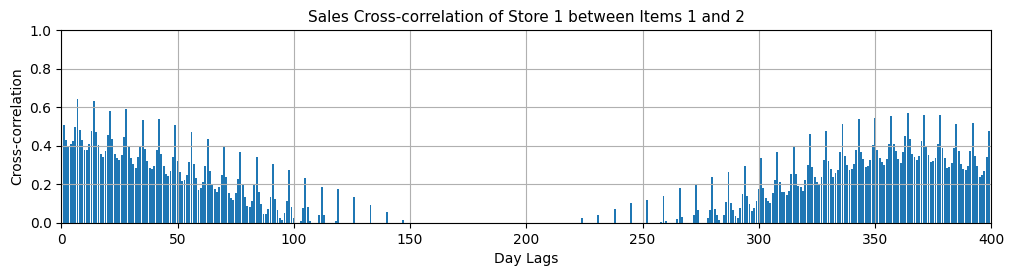

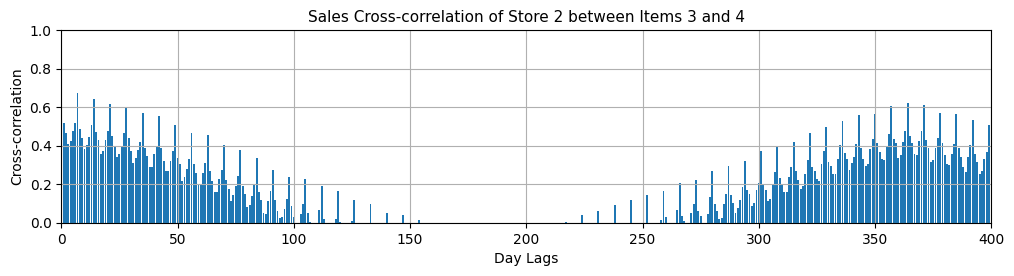

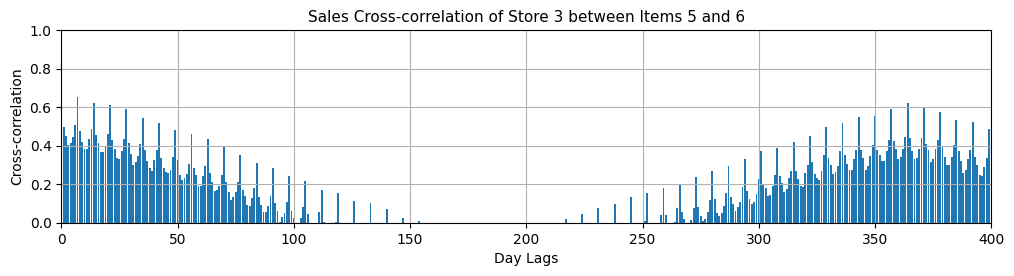

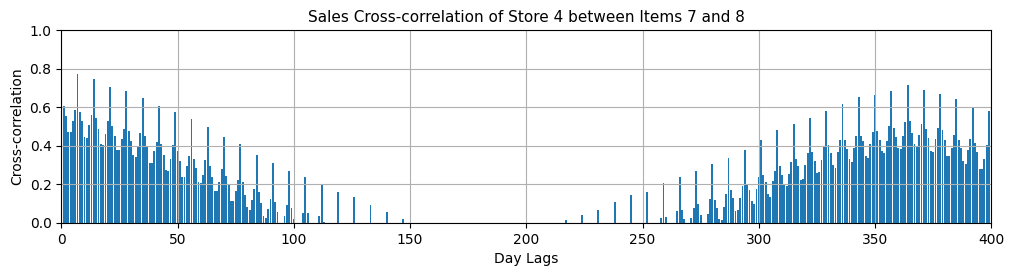

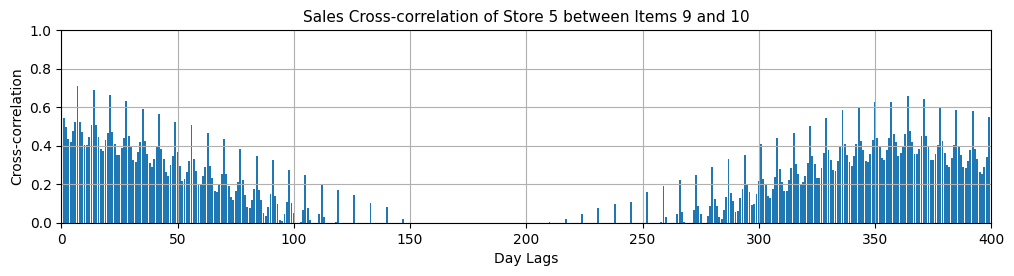

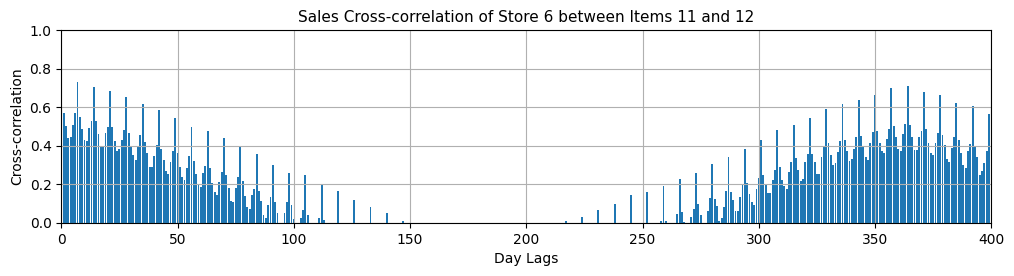

In [183]:
show_plot = True
save_plot = True  # Save the plots for offline analysis
cross_corr_folder = f"{base_folder}/images/cross_correlation"
_ = cross_correlation_of_item_sales_in_single_store(store=1, item_a=1, item_b=2, show_plot=show_plot, save=save_plot, save_folder=cross_corr_folder)
_ = cross_correlation_of_item_sales_in_single_store(store=2, item_a=3, item_b=4, show_plot=show_plot, save=save_plot, save_folder=cross_corr_folder)

_ = cross_correlation_of_item_sales_in_single_store(store=3, item_a=5, item_b=6, show_plot=show_plot, save=save_plot, save_folder=cross_corr_folder)
_ = cross_correlation_of_item_sales_in_single_store(store=4, item_a=7, item_b=8, show_plot=show_plot, save=save_plot, save_folder=cross_corr_folder)

_ = cross_correlation_of_item_sales_in_single_store(store=5, item_a=9,  item_b=10, show_plot=show_plot, save=save_plot, save_folder=cross_corr_folder)
_ = cross_correlation_of_item_sales_in_single_store(store=6, item_a=11, item_b=12, show_plot=show_plot, save=save_plot, save_folder=cross_corr_folder)

# From the plots we see below, all cross-correltion dominant peaks are higher than 0.5. So, the trend of general
# cross-correlation may exist. We will explore this trend in a larger scale next.


### Cross-correlation for All 50 Items
Doing this will take a long while, so we will skip the plot. We will only compute the ccf values for further analysis.

In [222]:
# Compute all cross-correlation for each store
day_lags = 400

all_store_ccf = dict()
for store in range(1, 11):
    print(f"Computing cross-correlation at store {store}")
    store_ccf = dict()
    for item_a in range(1, 50):
        a_ccf = dict()
        sales_a = stores[store][item_a]['sales']
        for item_b in range(item_a + 1, 51):  # Index start from item_a + 1 to save computation time.
            sales_b = stores[store][item_b]['sales']
            a_ccf[item_b] = ccf(sales_a, sales_b, nlags=day_lags)
        store_ccf[item_a] = a_ccf
    all_store_ccf[store] = store_ccf

Computing cross-correlation at store 1
Computing cross-correlation at store 2
Computing cross-correlation at store 3
Computing cross-correlation at store 4
Computing cross-correlation at store 5
Computing cross-correlation at store 6
Computing cross-correlation at store 7
Computing cross-correlation at store 8
Computing cross-correlation at store 9
Computing cross-correlation at store 10


In [224]:
# Get the peak value for each item pair of all stores.
all_store_peak_ccf = dict()
for store in range(1, 11):
    print(f"Finding peaks of cross-correlation at store {store}")
    store_ccf = all_store_ccf[store]
    store_peak_ccf = dict()
    for item_a in range(1, 50):
        a_ccf = store_ccf[item_a]
        peak_ccf = dict()
        for item_b in range(item_a + 1, 51):  # Index start from item_a + 1 to save computation time.
            peaks, _ = find_peaks(a_ccf[item_b])  
            dom_period = peaks[0]          
            peak_ccf[item_b] = a_ccf[item_b][dom_period]
        store_peak_ccf[item_a] = peak_ccf
    all_store_peak_ccf[store] = store_peak_ccf

Finding peaks of cross-correlation at store 1
Finding peaks of cross-correlation at store 2
Finding peaks of cross-correlation at store 3
Finding peaks of cross-correlation at store 4
Finding peaks of cross-correlation at store 5
Finding peaks of cross-correlation at store 6
Finding peaks of cross-correlation at store 7
Finding peaks of cross-correlation at store 8
Finding peaks of cross-correlation at store 9
Finding peaks of cross-correlation at store 10


In [227]:
# Because we expect that their correlation are not so small, we will count only incidents whose cross-correlation < 0.5.
print(f"Finding low cross-correlation between items at each store.")
corr_thr_pos = 0.5
corr_thr_neg = -0.5

# Count how many time each item appears with low cross-correlation, all stores combined.
total_item_ccf_counter = {i: 0 for i in range(1, 51)}
all_item_ccf_counter = dict()  # This one separate count for each store
for store in range(1, 11):
    store_ccf = all_store_peak_ccf[store]
    ccf_counter = {i: 0 for i in range(1, 51)}
    for item_a in range(1, 50):
        a_ccf = store_ccf[item_a]
        for item_b in range(item_a + 1, 51):  # Index start from item_a + 1 to save computation time.
            cc_val = a_ccf[item_b]
            if cc_val > corr_thr_neg and cc_val < corr_thr_pos:
                print(f"Low cross-correlation of item sales between Items {item_a} and {item_b} at Store {store}: ccf = {cc_val:.5f}")
                total_item_ccf_counter[item_a] += 1
                total_item_ccf_counter[item_b] += 1
                ccf_counter[item_a] += 1
                ccf_counter[item_b] += 1
    all_item_ccf_counter[store] = ccf_counter

Finding low cross-correlation between items at each store.
Low cross-correlation of item sales between Items 1 and 47 at Store 1: ccf = 0.36289
Low cross-correlation of item sales between Items 4 and 5 at Store 1: ccf = 0.49689
Low cross-correlation of item sales between Items 5 and 41 at Store 1: ccf = 0.32950
Low cross-correlation of item sales between Items 5 and 47 at Store 1: ccf = 0.49680
Low cross-correlation of item sales between Items 26 and 41 at Store 1: ccf = 0.39177
Low cross-correlation of item sales between Items 4 and 41 at Store 2: ccf = 0.44813
Low cross-correlation of item sales between Items 1 and 47 at Store 3: ccf = 0.39758
Low cross-correlation of item sales between Items 4 and 30 at Store 4: ccf = 0.45336
Low cross-correlation of item sales between Items 16 and 40 at Store 4: ccf = 0.41847
Low cross-correlation of item sales between Items 16 and 47 at Store 4: ccf = 0.39971
Low cross-correlation of item sales between Items 21 and 47 at Store 4: ccf = 0.46073
Low

In [231]:
# Analyze low cross-correlation incidents of item pairs in each store.
# 1. Sort the counters by value
total_sorted = sorted(total_item_ccf_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
print("Total counter:", total_sorted)

print("\nStore counter:")
for store in range(1, 11):
    item_counter = all_item_ccf_counter[store]
    item_sorted = sorted(item_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
    print(f"\tStore {store}: {item_sorted[0:5]}")  # Print only top-5 low correlation incidents

# 2. Read the result from below outputs
# It seems that only Stores 5, 6, 7 may have some issues with low cross-correlation between items.
# However, when considering that each item must pair with other 49 items, the low cross-correlation incidents are
#   normally small (max = 14 out of 49). So, we will assume that items generally have at least moderate 
#   cross-correlation, but further investigation about grouping an item with or separating it from others worths
#   further investigation, especially for Store 7.

Total counter: [(5, 39), (47, 36), (1, 34), (41, 33), (27, 31), (4, 28), (16, 21), (23, 18), (49, 15), (34, 15), (40, 11), (44, 10), (37, 9), (17, 8), (42, 6), (36, 4), (50, 2), (39, 2), (32, 2), (31, 2), (26, 2), (19, 2), (9, 2), (3, 2), (38, 1), (35, 1), (30, 1), (25, 1), (24, 1), (21, 1), (14, 1), (2, 1), (48, 0), (46, 0), (45, 0), (43, 0), (33, 0), (29, 0), (28, 0), (22, 0), (20, 0), (18, 0), (15, 0), (13, 0), (12, 0), (11, 0), (10, 0), (8, 0), (7, 0), (6, 0)]

Store counter:
	Store 1: [(5, 3), (47, 2), (41, 2), (26, 1), (4, 1)]
	Store 2: [(41, 1), (4, 1), (50, 0), (49, 0), (48, 0)]
	Store 3: [(47, 1), (1, 1), (50, 0), (49, 0), (48, 0)]
	Store 4: [(47, 2), (16, 2), (40, 1), (30, 1), (21, 1)]
	Store 5: [(47, 10), (4, 10), (27, 8), (5, 8), (1, 8)]
	Store 6: [(5, 11), (41, 9), (23, 9), (27, 8), (1, 8)]
	Store 7: [(47, 14), (41, 14), (5, 14), (1, 14), (27, 12)]
	Store 8: [(50, 0), (49, 0), (48, 0), (47, 0), (46, 0)]
	Store 9: [(27, 3), (5, 3), (1, 2), (49, 1), (47, 1)]
	Store 10: [(50,

## Inter-store Cross-correlation of Single Item
Similarly from the previous data exploration, we will check how sales of each item correlates across stores. <br>
Indexing will focus on item first and them store pairing, so it will be dict[item][store_a][store_b].

In [202]:
def cross_correlation_of_single_item_sales_between_two_stores(item, store_a, store_b, day_lags=400, 
                                xsize=12, ysize=2.5, show_plot=True, save=False, save_folder=None):
    """Compute and plot cross-correlation of one specific items at two specific stores. Plot and/or save outptus if 
    requested. Cross-correlation values are returned for further analysis."""

    # Calculate autocorrelation coefficients
    sales_a, sales_b = stores[store_a][item]['sales'], stores[store_b][item]['sales']
    ccf_values = ccf(sales_a, sales_b, nlags=day_lags)

    plt.ioff()

    # Plot the bar chart
    lags = np.arange(len(ccf_values))
    plt.figure(figsize=(xsize, ysize))
    plt.bar(lags, ccf_values)  # use bar plot

    plt.xlim([0, day_lags])
    plt.ylim([0, 1])

    plt.title(f"Sales Cross-correlation of Item {item} between Stores {store_a} and {store_b}", fontsize=11)
    plt.xlabel("Day Lags", fontsize=10)
    plt.ylabel("Cross-correlation", fontsize=10)

    plt.grid(True)

    if save:
        assert save_folder is not None
        plt.savefig(f"{save_folder}/cross_corr_item{item}_stores{store_a}_{store_b}.png", bbox_inches='tight')

    if show_plot:
        plt.show()
    plt.close()
        
    return ccf_values

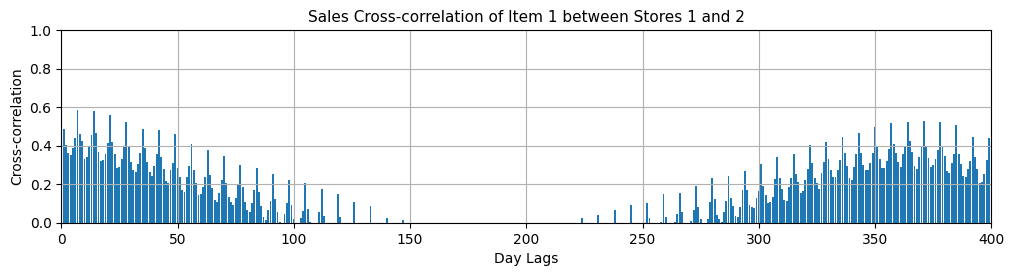

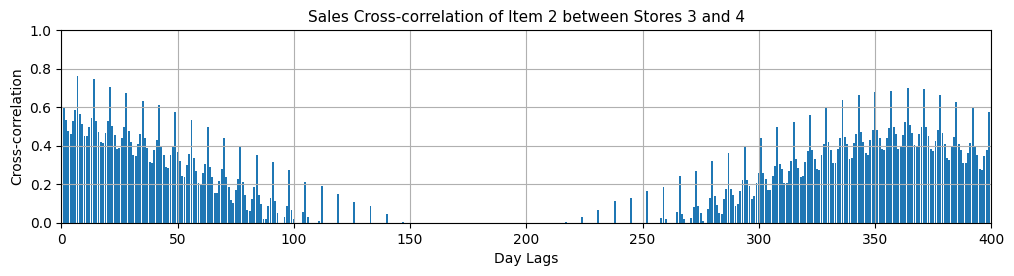

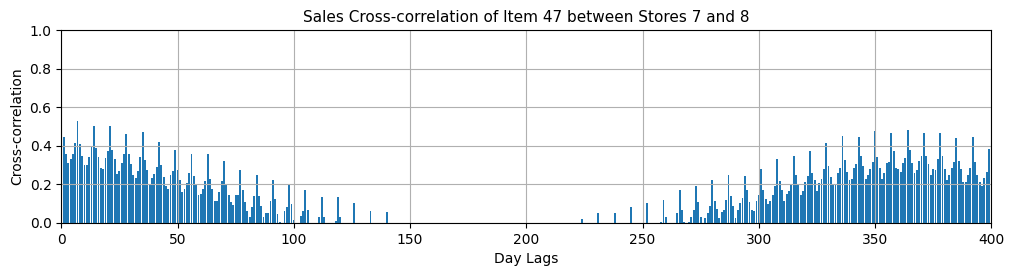

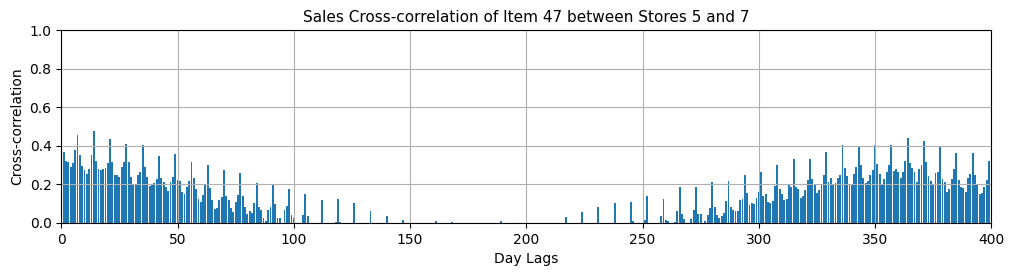

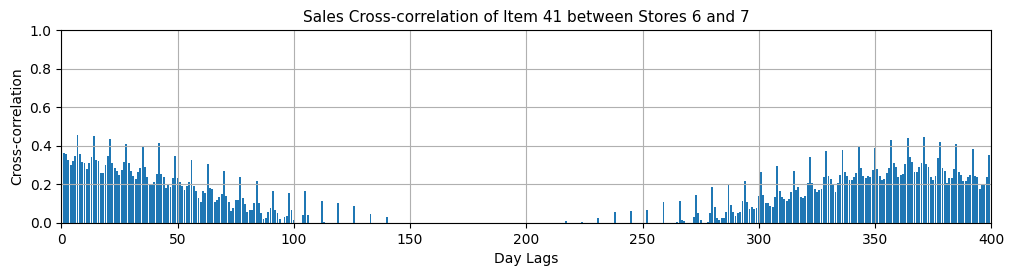

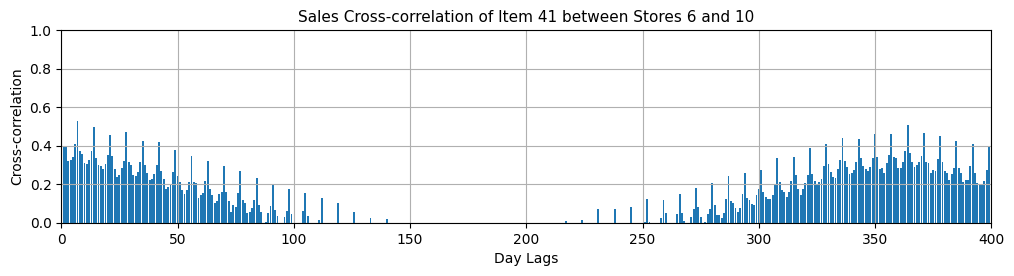

In [ ]:
# Generate exploratory plots for items with moderate correlation (Items 1, 2) and for items with low correlation (Items 47, 46)
# We also try pairing stores with low correlation, and also try pairing one store with low correlation and another with
#   moderate correlation. Note: by 'moderate', we mean > 0.5, although it may be high correlation in some cases.
show_plot = True
save_plot = True  # Save the plots for offline analysis
store_corr_folder = f"{base_folder}/images/corr_1item_2stores"
_ = cross_correlation_of_single_item_sales_between_two_stores(item=1, store_a=1, store_b=2, show_plot=show_plot, save=save_plot, save_folder=store_corr_folder)
_ = cross_correlation_of_single_item_sales_between_two_stores(item=2, store_a=3, store_b=4, show_plot=show_plot, save=save_plot, save_folder=store_corr_folder)

_ = cross_correlation_of_single_item_sales_between_two_stores(item=47, store_a=7, store_b=8, show_plot=show_plot, save=save_plot, save_folder=store_corr_folder)
_ = cross_correlation_of_single_item_sales_between_two_stores(item=47, store_a=5, store_b=7, show_plot=show_plot, save=save_plot, save_folder=store_corr_folder)

_ = cross_correlation_of_single_item_sales_between_two_stores(item=41, store_a=6, store_b=7, show_plot=show_plot, save=save_plot, save_folder=store_corr_folder)
_ = cross_correlation_of_single_item_sales_between_two_stores(item=41, store_a=6, store_b=10, show_plot=show_plot, save=save_plot, save_folder=store_corr_folder)

# As expected, items with moderate correlation on both paired stores will have moderate correlation. However, if one
#   of them has low correlation, the resulting correlation will be on the edge of low correlation (Item 47, Stores 7 + 8
#   and Item 41, Stores 6 + 10). When both stores have low correlation on an item, their cross correlation over the item
#   is low, naturally.

### Compute and Summarize Cross-correlation of Single Item Sales across Two Stores

In [234]:
# Compute all inter-store cross-correlation of each item.
day_lags = 400
all_item_ccf = dict()
for item in range(1, 51):
    item_ccf = dict()
    for store_a in range(1, 11):
        a_ccf = dict()
        sales_a = stores[store_a][item]['sales']
        for store_b in range(1, 11):
            sales_b = stores[store_b][item]['sales']
            a_ccf[store_b] = ccf(sales_a, sales_b, nlags=day_lags)
        item_ccf[store_a] = a_ccf
    all_item_ccf[item] = item_ccf

In [236]:
# Get the peak value for each store pair of all items.
all_item_peak_ccf = dict()
for item in range(1, 51):
    print(f"Finding peaks of cross-correlation for Item {item}")
    item_ccf = all_item_ccf[item]
    item_peak_ccf = dict()
    for store_a in range(1, 11):
        a_ccf = item_ccf[store_a]
        peak_ccf = dict()
        for store_b in range(store_a + 1, 11):  # Index start from store_a + 1 to save computation time.
            peaks, _ = find_peaks(a_ccf[store_b])  
            dom_period = peaks[0]          
            peak_ccf[store_b] = a_ccf[store_b][dom_period]
        item_peak_ccf[store_a] = peak_ccf
    all_item_peak_ccf[item] = item_peak_ccf

Finding peaks of cross-correlation for Item 1
Finding peaks of cross-correlation for Item 2
Finding peaks of cross-correlation for Item 3
Finding peaks of cross-correlation for Item 4
Finding peaks of cross-correlation for Item 5
Finding peaks of cross-correlation for Item 6
Finding peaks of cross-correlation for Item 7
Finding peaks of cross-correlation for Item 8
Finding peaks of cross-correlation for Item 9
Finding peaks of cross-correlation for Item 10
Finding peaks of cross-correlation for Item 11
Finding peaks of cross-correlation for Item 12
Finding peaks of cross-correlation for Item 13
Finding peaks of cross-correlation for Item 14
Finding peaks of cross-correlation for Item 15
Finding peaks of cross-correlation for Item 16
Finding peaks of cross-correlation for Item 17
Finding peaks of cross-correlation for Item 18
Finding peaks of cross-correlation for Item 19
Finding peaks of cross-correlation for Item 20
Finding peaks of cross-correlation for Item 21
Finding peaks of cross

In [238]:
# Because we expect that their correlation are not so small, we will count only incidents whose cross-correlation < 0.5.
print(f"Finding low cross-correlation between stores for each item.")
corr_thr_pos = 0.5
corr_thr_neg = -0.5

# Count how many time each store appears with low cross-correlation, all items combined.
total_store_low_ccf_counter = {i: 0 for i in range(1, 11)}
all_store_low_ccf_counter = dict()  # This one separate count for each item
for item in range(1, 51):
    item_ccf = all_item_peak_ccf[item]
    ccf_counter = {i: 0 for i in range(1, 11)}
    for store_a in range(1, 11):
        a_ccf = item_ccf[store_a]
        for store_b in range(store_a + 1, 11):  # Index start from store_a + 1 to save computation time.
            cc_val = a_ccf[store_b]
            if cc_val > corr_thr_neg and cc_val < corr_thr_pos:
                print(f"Low cross-correlation of item sales between Stores {store_a} and {store_b} for Item {item}: ccf = {cc_val:.5f}")
                total_store_low_ccf_counter[store_a] += 1
                total_store_low_ccf_counter[store_b] += 1
                ccf_counter[store_a] += 1
                ccf_counter[store_b] += 1
    all_store_low_ccf_counter[item] = ccf_counter

Finding low cross-correlation between stores for each item.
Low cross-correlation of item sales between Stores 4 and 5 for Item 1: ccf = 0.49993
Low cross-correlation of item sales between Stores 5 and 6 for Item 1: ccf = 0.32191
Low cross-correlation of item sales between Stores 5 and 7 for Item 1: ccf = 0.33018
Low cross-correlation of item sales between Stores 6 and 7 for Item 1: ccf = 0.46306
Low cross-correlation of item sales between Stores 1 and 4 for Item 4: ccf = 0.35887
Low cross-correlation of item sales between Stores 1 and 7 for Item 4: ccf = 0.48562
Low cross-correlation of item sales between Stores 4 and 7 for Item 4: ccf = 0.49581
Low cross-correlation of item sales between Stores 5 and 6 for Item 4: ccf = 0.49353
Low cross-correlation of item sales between Stores 5 and 7 for Item 4: ccf = 0.45598
Low cross-correlation of item sales between Stores 5 and 8 for Item 4: ccf = 0.35604
Low cross-correlation of item sales between Stores 5 and 9 for Item 4: ccf = 0.48533
Low c

In [242]:
# Analyze low cross-correlation incidents of store pairs for each item.
# 1. Sort the counters by value
total_sorted = sorted(total_store_low_ccf_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
print("Total low-correlation counter for store pairs:", total_sorted)

print("\nItem low-correlation counter for each store:")
print("Format = Item item_id: [(store_id, low correlation count for this store), ...]")
for item in range(1, 51):
    item_counter = all_store_low_ccf_counter[item]
    item_sorted = sorted(item_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
    
    # Print only top-5 low correlation incidents, and only when there is low correlation
    if item_sorted[0][1] > 0:
        print(f"\tItem {item}: {item_sorted[0:5]}")  

# 2. Read the result from below outputs
# It seems that only Stores 5, 6, 7 may have some issues with low cross-correlation between items.
# However, when considering that each item must pair with other 49 items, the low cross-correlation incidents are
#   normally small (max = 14 out of 49). So, we will assume that items generally have at least moderate 
#   cross-correlation, but further investigation about grouping an item with or separating it from others worths
#   further investigation, especially for Store 7.

Total low-correlation counter for store pairs: [(7, 28), (5, 21), (6, 14), (1, 10), (4, 8), (9, 7), (2, 5), (10, 4), (8, 4), (3, 3)]

Item low-correlation counter for each store:
Format = Item item_id: [(store_id, low correlation count for this store), ...]
	Item 1: [(5, 3), (7, 2), (6, 2), (4, 1), (10, 0)]
	Item 4: [(7, 4), (5, 4), (6, 2), (4, 2), (1, 2)]
	Item 5: [(7, 9), (5, 6), (6, 5), (1, 5), (9, 4)]
	Item 23: [(9, 1), (5, 1), (10, 0), (8, 0), (7, 0)]
	Item 27: [(7, 3), (6, 2), (5, 2), (2, 2), (1, 2)]
	Item 40: [(10, 1), (7, 1), (9, 0), (8, 0), (6, 0)]
	Item 41: [(7, 6), (5, 4), (6, 2), (4, 2), (2, 2)]
	Item 47: [(7, 3), (9, 1), (6, 1), (5, 1), (4, 1)]


# Transform Data to Prepare for Multivariate Forecasting on both Input and Output
Although Stores 5, 6, and 7 may have some low-cross-correlation issues, I still believe that combining them with other
stores may be helpful. In addition, if time permitted, it is desirable to compare validation accuracy when these stores
or some items from some stores were removed and analyzed as independent data series.

Separating some variable into other groups and train other prediction models can reduce the complexity of the model too.
Nonetheless, at this moment, we will combine everything and organize the data columns as follows.
1. Column 0: Date
2. Columns 1 - 10: Sales of Item 1 from Stores 1 to 10.
3. Columns 11 - 20: Sales of Item 2 from Stores 1 to 10.
4. Columns 21 - 30: Sales of Item 3 from Stores 1 to 10.
...
5. Columns 491 - 500: Sales of Item 50 from Stores 1 to 10.

In [ ]:
# Merge all stores and all items -> 500 columns, 1 file
merged_df = pd.DataFrame(stores[store_a][item]['date'].reset_index(drop=True))
for item in range(1, 51):
    for store in range(1, 11):
        merged_df[f"it{item}_st{store}"] = stores[store][item]['sales'].reset_index(drop=True)

merged_df = merged_df.copy()  # Obtain a de-fragmented copy
merged_df.to_csv(f"{base_folder}/multivar_train.csv")

C:\Users\pinyo\AppData\Local\Temp\ipykernel_37556\327399523.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f"it{item}_st{store}"] = stores[store][item]['sales'].reset_index(drop=True)
C:\Users\pinyo\AppData\Local\Temp\ipykernel_37556\327399523.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f"it{item}_st{store}"] = stores[store][item]['sales'].reset_index(drop=True)
C:\Users\pinyo\AppData\Local\Temp\ipykernel_37556\327399523.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [272]:
# Merge all items, separate stores -> 50 columns, 10 files
for store in range(1, 11):
    merged_df = pd.DataFrame(stores[store][item]['date'].reset_index(drop=True))
    for item in range(1, 51):
        merged_df[f"it{item}_st{store}"] = stores[store][item]['sales'].reset_index(drop=True)

    merged_df = merged_df.copy()  # Obtain a de-fragmented copy
    merged_df.to_csv(f"{base_folder}/multivar_train_50items_store{store}.csv", index=False)

print("Merging Items: DONE")

Merging Items: DONE


In [273]:
# Merge all stores, separate items -> 10 columns, 50 files
for item in range(1, 51):
    merged_df = pd.DataFrame(stores[store][item]['date'].reset_index(drop=True))
    for store in range(1, 11):    
        merged_df[f"it{item}_st{store}"] = stores[store][item]['sales'].reset_index(drop=True)

    merged_df = merged_df.copy()  # Obtain a de-fragmented copy
    merged_df = merged_df[1:]
    merged_df.to_csv(f"{base_folder}/multivar_train_10stores_item{item}.csv", index=False)

print("Merging Stores (Item focus): DONE")

Merging Stores (Item focus): DONE


In [269]:
DataGrid(merged_df)

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [174]:
item = 1
item_a, item_b = 1, 2
day_lags = 400
sales_a, sales_b = stores[item][item_a]['sales'], stores[item][item_b]['sales']
ccf_values = ccf(sales_a, sales_b, nlags=day_lags)

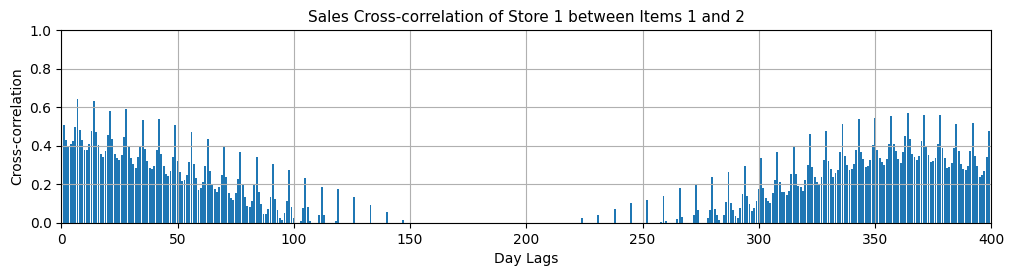

In [175]:
# Plot the bar chart
xsize, ysize = 12, 2.5
lags = np.arange(len(ccf_values))
plt.figure(figsize=(xsize, ysize))
plt.bar(lags, ccf_values)  # use bar plot

plt.xlim([0, day_lags])
plt.ylim([0, 1])

plt.title(f"Sales Cross-correlation of Store {item} between Items {item_a} and {item_b}", fontsize=11)
plt.xlabel("Day Lags", fontsize=10)
plt.ylabel("Cross-correlation", fontsize=10)

plt.grid(True)
plt.show()
plt.close()

In [46]:
print(stores[1][1]['date'][0])
print(stores[1][1]['date'][1])
date1 = datetime.strptime(stores[1][1]['date'][1], '%Y-%m-%d').date()
date0 = datetime.strptime(stores[1][1]['date'][0], '%Y-%m-%d').date()
print(type(date1))
print(date1 - date0)

2013-01-01
2013-01-02
<class 'datetime.date'>
1 day, 0:00:00
